Notebook with streamlined processing of V1DD-2P datasets.

Our processing steps consist of the following:
1. Filter data by stimulus epochs
   - Responses associated with each epoch is returned as an individual element of list, i.e. `dff_traces` now becomes a list of traces, one for each stimulus epoch
2. Standardize data
   - `dff_traces`: No scaling
   - `behavior_traces`: Standard scaling per feature, for all filtered data.
3. Bin response
   - Average traces by 2s windows, 1s overlap

--- 

**Summary**
- Just working with dF/F traces as they are given; omitting min-max scaling of dF/F because it amplifies noise in neurons that have very low activity
- Binning with 2s windows and 1s overlap

**Next steps**
- Begin exploring synchronous clustering algorithms

*Nice-to-haves*
- Histogram of raw `dff_traces` values to show how we selected the min and max percentiles for scaling. Right now, eyeballing the values and selecting the 0.5th and 99.9th percentiles
- Behavioral regression
  - Standard scale the behavior variables (by stimulus epoch)
  - Ridge regresssion!!! Extreme collinearity between pupil and running.
  - Vergil: Try out a behavioral gain (multiplicative) modulation. Let A and B be the two behavioral traces. Construct a 3rd variable, $x_C = x_A x x_B$. Now, fit a linear (ridge) regression to the 3 variables. Residuals consist of (pay close attention!!!!:  $$y_\textrm{resid} = [y_A - \hat{y}_A, y_B - \hat{y}_B, y_C/\hat{y}_C]$$
    - Gain modulation of behavioral variables is definitely observed in the visual cortex.
  - Vergil: Using a more complicated model,
  - Minor: Time lagged behavioral variables (although binning should help!)


In [ ]:
%load_ext autoreload
%autoreload 2

# general imports 
import os
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm

import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# Add package to path
import sys
sys.path.insert(0, '/root/capsule/code/src')
from funcky.utils import (
    load_nwb_session,
    get_aligned_session_data,
    get_epoch_data,
    bin_and_avg_data,
)

In [2]:
# Specify data directory location
DATA_DIR = "/data/"  # Code Ocean

# Load metadata csv, which contains session, subject, column, and volume info
metadata = pd.read_csv('/root/capsule/metadata/V1DD_metadata.csv')

## Load and process data

In [ ]:
selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==3)           # not top or bottom volume
]

assert len(selected_session) == 1, \
    f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)
session_data = get_aligned_session_data(nwb)

# =============================================================================
# Get stimulus epochs of interest
selected_stimuli = [
    'drifting_gratings_full',
    'spontaneous',
    'natural_movie',
]

stim_epochs_df = nwb.epochs.to_dataframe()
stim_epochs_df = stim_epochs_df[
    stim_epochs_df['stim_name'].isin(selected_stimuli)
]

# =============================================================================
# Filter data
list_of_epoch_data = [
    get_epoch_data(session_data, start_time, stop_time)
    for start_time, stop_time in zip(stim_epochs_df.start_time.values, stim_epochs_df.stop_time.values)
]

# Apply scaling and other processing
# - dff_traces : no additional processing needed
pass

# - behavior_traces : apply standard scaling to each feature independently
# Fit scaler to all data that we are analyzing
list_of_bhv_traces = [dd['behavior_traces'] for dd in list_of_epoch_data]
all_bhv_traces = np.concatenate(list_of_bhv_traces, axis=0) # shape (n_total_time, n_behave)
all_bhv_traces = StandardScaler().fit_transform(all_bhv_traces)

# Update epoch data with scaled behavior traces
split_idxs = np.cumsum([len(arr) for arr in list_of_bhv_traces])[:-1]
for dd, bhv_traces in zip(list_of_epoch_data, np.array_split(all_bhv_traces, split_idxs)):
    dd['behavior_traces'] = bhv_traces

# =============================================================================
# Bin responses
window_size, window_overlap = 2., 1.

list_of_epoch_data = [
    bin_and_avg_data(epoch_data, window_size, window_overlap)
    for epoch_data in list_of_epoch_data
]5-+

## Load and process data -- walk through

In [ ]:
selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==3)           # not top or bottom volume
]

assert len(selected_session) == 1, f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)
session_data = get_aligned_session_data(nwb)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:166: UserWarning: pupil: 516 NaNs detected; fillin in via interpolation.
  warnings.warn(


### Filter data and standard scale by epochs of interest

We will focus our analyses to the `drifting_gratings_full`, `spontaneous`, and `natural_movie` epochs.

In [4]:
selected_stimuli = [
    'drifting_gratings_full',
    'spontaneous',
    'natural_movie',
]

stim_epochs_df = nwb.epochs.to_dataframe()
stim_epochs_df = stim_epochs_df[
    stim_epochs_df['stim_name'].isin(selected_stimuli)
]
stim_epochs_df

stim_name   start_time    stop_time    duration
id                                                              
0   drifting_gratings_full    54.634430   341.856873  287.222443
3              spontaneous   876.318604  1176.552002  300.233398
5            natural_movie  1343.707764  1794.066162  450.358398
9   drifting_gratings_full  2704.841309  2992.063721  287.222412
10           natural_movie  2997.084473  3537.517822  540.433350

In [ ]:
list_of_epoch_data = [
    get_epoch_data(session_data, start_time, stop_time)
    for start_time, stop_time in zip(stim_epochs_df.start_time.values, stim_epochs_df.stop_time.values)
]

# Apply scaling and other processing
# - dff_traces : no additional processing needed
pass

# - behavior_traces : apply standard scaling to each feature independently
# Fit scaler to all data that we are analyzing
list_of_bhv_traces = [dd['behavior_traces'] for dd in list_of_epoch_data]
all_bhv_traces = np.concatenate(list_of_bhv_traces, axis=0) # shape (n_total_time, n_behave)
all_bhv_traces = StandardScaler().fit_transform(all_bhv_traces)

# Update epoch data with scaled behaior traces
split_idxs = np.cumsum([len(arr) for arr in list_of_bhv_traces])[:-1]
for dd, bhv_traces in zip(list_of_epoch_data, np.array_split(all_bhv_traces, split_idxs)):
    dd['behavior_traces'] = bhv_traces

**Visualize population average**

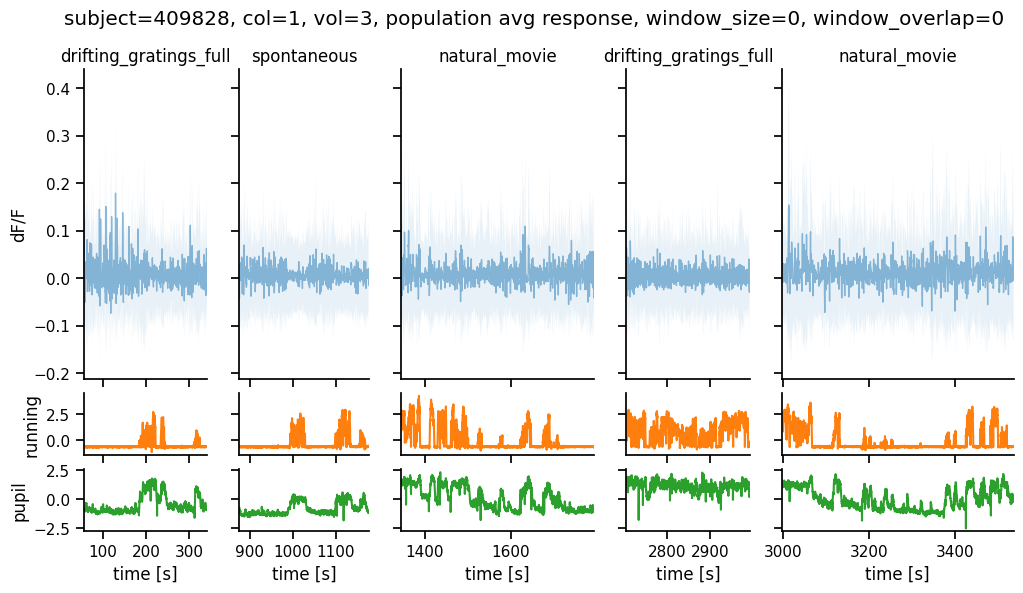

In [6]:
session_data_ = list_of_epoch_data

row_labels = ['dF/F', 'running', 'pupil']

# =========================================================================
width_ratios = np.array([len(dd['timestamps']) for dd in session_data_])

fig, axs = plt.subplots(
    ncols=len(width_ratios), width_ratios=width_ratios, sharey="row",
    nrows=len(row_labels), height_ratios=[1,0.2,0.2], sharex="col",
    figsize=(12,6)
)
fig.subplots_adjust(wspace=0.2, hspace=0.1,)

# Loop through each column, i.e. each stimulus epoch
for i_col, dd in zip(range(axs.shape[-1]), session_data_):

    _ts = dd['timestamps']
    _dff = dd['dff_traces']
    _bhv = dd['behavior_traces']
    _dff_avg = _dff.mean(axis=-1)
    _dff_std = _dff.std(axis=-1)

    # ----------------------------------
    # Row 1: Plot avg population trace
    # ----------------------------------
    i_row = 0
    ax = axs[i_row,i_col]
    ax.plot(_ts, _dff_avg, lw=1, alpha=0.5, c='C0')
    ax.fill_between(
        _ts, _dff_avg-_dff_std, _dff_avg+_dff_std,
        color='C0', ec='none', alpha=0.1, zorder=1
    )  # 1 std

    # ----------------------------------
    # Rows 2+: Plot behavior traces
    # ----------------------------------
    for i_row in range(1, len(axs)):
        ax = axs[i_row,i_col]
        name = row_labels[i_row]

        ax.plot(_ts, _bhv[:,i_row-1], color=f'C{i_row}')    
    
# Make pretty!
for (i_row, i_col), ax in np.ndenumerate(axs):
    ax.margins(x=0.0)

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel('time [s]')
    
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(row_labels[i_row])

    if ax.get_subplotspec().is_first_row():
        ax.set_title(stim_epochs_df.iloc[i_col]['stim_name'])

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + ', population avg response, window_size=0, window_overlap=0',
)

sns.despine()

**Visualize per neuron**

Text(0.5, 0.95, 'subject=409828, col=1, vol=3, single neuron response, window_size=0, window_overlap=0')

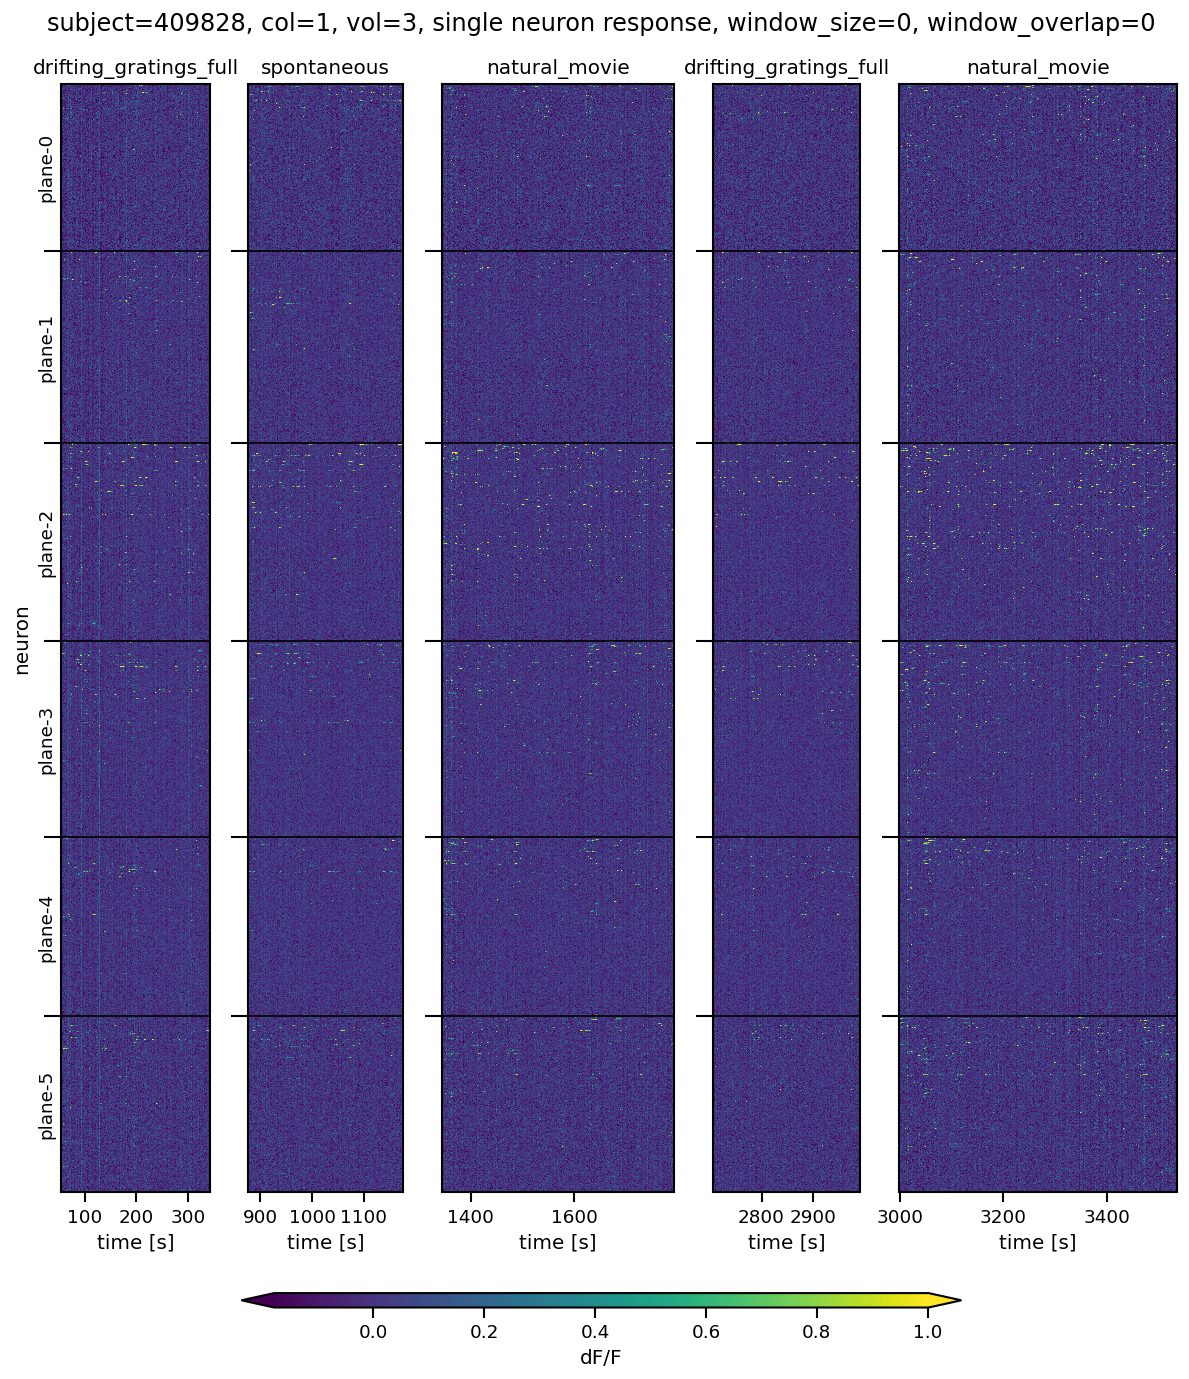

In [7]:
session_data_ = list_of_epoch_data

# Share heatmap vmin and vmap across epochs
concat_dff = np.concatenate([dd['dff_traces'] for dd in session_data_], axis=0)  # (n_total_timesteps, n_total_neurons)
vmin = np.percentile(concat_dff, 1)
vmax = np.percentile(concat_dff, 99.9)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Add horizontal line indicators of planes
plane_ids = session_data_[0]['plane_ids']
y_cluster_edges = np.nonzero(plane_ids[1:] - plane_ids[:-1])[0] + 1

y_cluster_centers = np.concatenate([
    [0.5*y_cluster_edges[0]],  # first cluster
    0.5*(y_cluster_edges[1:] - y_cluster_edges[:-1]) + y_cluster_edges[:-1],
    [0.5*(len(plane_ids) - y_cluster_edges[-1]) + y_cluster_edges[-1]]  # last cluster
])

y_cluster_labels = [f'plane-{plane_id}' for plane_id in np.unique(plane_ids)]

# =========================================================================
width_ratios = np.array([len(dd['timestamps']) for dd in session_data_])

fig, axs = plt.subplots(
    ncols=len(width_ratios), width_ratios=width_ratios, sharey="row", figsize=(12,12), dpi=120,
)

for ax, dd, epoch_name in zip(axs, session_data_, stim_epochs_df['stim_name'].values):
    _dff = dd['dff_traces']  # shape (n_epoch_timesteps, n_total_cells)
    _ts = dd['timestamps']   # shape (n_epoch_timesteps,)
    
    im = ax.imshow(
        _dff.T, norm=norm, interpolation='none', aspect='auto',
        extent=[_ts[0], _ts[-1], _dff.shape[-1], 0]
    )

    # Annotate y-axis with plane id
    for edge in y_cluster_edges:
        ax.axhline(edge, color='k', lw=1)

    ax.set_yticks(y_cluster_edges)
    ax.tick_params(axis='y', labelleft=False, length=10)

    ax.set_yticks(y_cluster_centers, minor=True)
    ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
    ax.tick_params(axis='y', which='minor', left=False, length=0)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('neuron')

    ax.set_xlabel("time [s]")
    ax.set_title(epoch_name)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, label='dF/F', orientation='horizontal', extend='both')

# Add title
fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + ', single neuron response, window_size=0, window_overlap=0',
    y=0.95
)

### Bin neural responses

We apply a sliding window average for a 2s window size with 1s overlap between windows.

In [8]:
def bin_and_avg(arr, timestamps, window_size, window_overlap=0.):
    """Sliding window average of data, based on timestamps.

    Parameters
    ----------
    arr : np.ndarray, shape (T,).
        Array to bin and average.

    timestamps : np.ndarray, shape (T,)
        Timestamps to calculate bins.

    window_size : float.
        Window size, in same units as timestamps.

    window_overlap : float, default=0.
        Window overlap, in same units as `timestamps`.
        Default : 0, no overlap.

    Returns
    -------
    binned_arr : np.ndarray, shape (T_bins,...).
        Arrays with values binned and averaged.

    bin_starts : np.ndarray, shape (T_bins,).
        Array of timestamps associated with bin starts.

    """

    T = len(timestamps)
    if len(arr) != T:
        raise ValueError(
            f"Expect arrays to have length {T}, but got shape={arr.shape}."
        )

    # Calculate bin start times
    step_size = window_size - window_overlap
    bin_starts = np.arange(timestamps[0], timestamps[-1] - window_size + step_size, step_size)
    bin_ends = bin_starts + window_size
    
    binned_arr = np.zeros((len(bin_starts),) + arr.shape[1:])
    for i_bin, (start, end) in enumerate(zip(bin_starts, bin_ends)):
        # Find indices of timestamps within the current bin
        mask = (timestamps >= start) & (timestamps <= end)

        if mask.sum() > 0:  # Calculate the mean of the array within the current bin
            binned_arr[i_bin] = arr[mask].mean(axis=0)
        
        else: # Else, empty bin
            binned_arr[i_bin] = np.nan

    return binned_arr, bin_starts

def bin_and_avg_data(session_data, window_size, window_overlap=0.):
    """Helper function for applying `bin_and_avg` to session data dictionary."""

    binned_dd = {}
    for k, v in dd.items():
        if (k=='timestamps'):  # we'll handle timestamps at the end
            continue
        elif '_traces' in k:       # apply binning
            binned_v, binned_ts = bin_and_avg(v, dd['timestamps'], window_size, window_overlap)
            binned_dd[k] = binned_v
        else:  # else, do nothing
            binned_dd[k] = v
    
    # addd binned_ts
    binned_dd['timestamps'] = binned_ts

    return binned_dd

In [9]:
window_size, window_overlap = 2., 1.

list_of_binned_epoch_data = [
    bin_and_avg_data(epoch_data, window_size, window_overlap)
    for epoch_data in list_of_epoch_data
]

# # Sanity check: Print elements of each data dictionary
# for epoch_name, epoch_data in zip(stim_epochs_df['stim_name'].values, list_of_binned_epoch_data):
#     print(f"{epoch_name}")
#     for k, v in epoch_data.items():
#         print(f"{k}: {v.shape}")
        
#     print()

There are fewer timestamps here, and they are consitent within each dictionary. That's good.

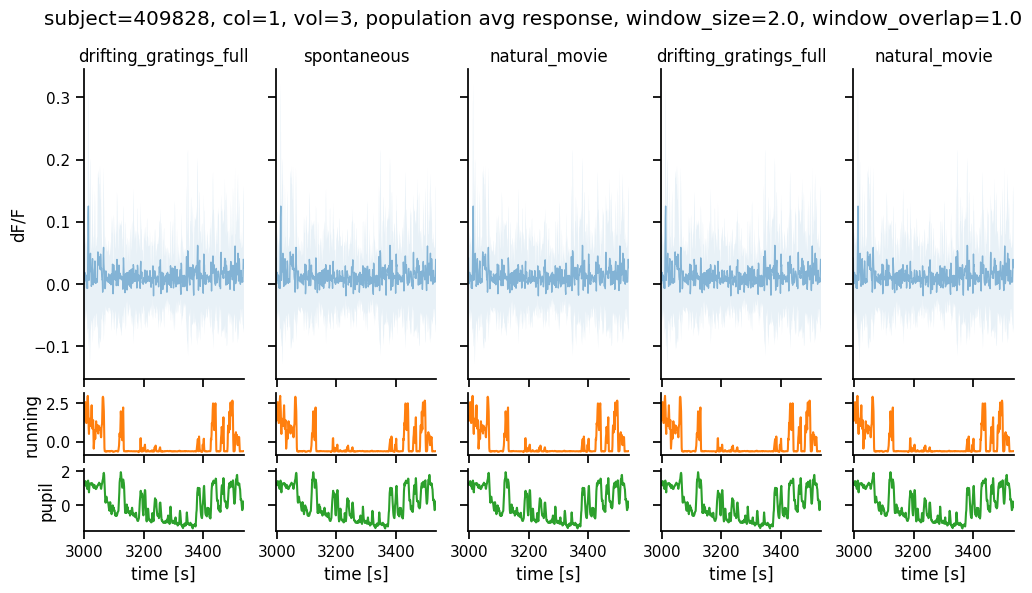

In [10]:
session_data_ = list_of_binned_epoch_data

row_labels = ['dF/F', 'running', 'pupil']

# =========================================================================
width_ratios = np.array([len(dd['timestamps']) for dd in session_data_])

fig, axs = plt.subplots(
    ncols=len(width_ratios), width_ratios=width_ratios, sharey="row",
    nrows=len(row_labels), height_ratios=[1,0.2,0.2], sharex="col",
    figsize=(12,6)
)
fig.subplots_adjust(wspace=0.2, hspace=0.1,)

# Loop through each column, i.e. each stimulus epoch
for i_col, dd in zip(range(axs.shape[-1]), session_data_):

    _ts = dd['timestamps']
    _dff = dd['dff_traces']
    _bhv = dd['behavior_traces']
    _dff_avg = _dff.mean(axis=-1)
    _dff_std = _dff.std(axis=-1)

    # ----------------------------------
    # Row 1: Plot avg population trace
    # ----------------------------------
    i_row = 0
    ax = axs[i_row,i_col]
    ax.plot(_ts, _dff_avg, lw=1, alpha=0.5, c='C0')
    ax.fill_between(
        _ts, _dff_avg-_dff_std, _dff_avg+_dff_std,
        color='C0', ec='none', alpha=0.1, zorder=1
    )  # 1 std

    # ----------------------------------
    # Rows 2+: Plot behavior traces
    # ----------------------------------
    for i_row in range(1, len(axs)):
        ax = axs[i_row,i_col]
        name = row_labels[i_row]

        ax.plot(_ts, _bhv[:,i_row-1], color=f'C{i_row}')    
    
# Make pretty!
for (i_row, i_col), ax in np.ndenumerate(axs):
    ax.margins(x=0.0)

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel('time [s]')
    
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(row_labels[i_row])

    if ax.get_subplotspec().is_first_row():
        ax.set_title(stim_epochs_df.iloc[i_col]['stim_name'])

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + f', population avg response, {window_size=}, {window_overlap=}',
)

sns.despine()

#### Per-neuron response

Text(0.5, 0.95, 'subject=409828, col=1, vol=3, single neuron response, window_size=2.0, window_overlap=1.0')

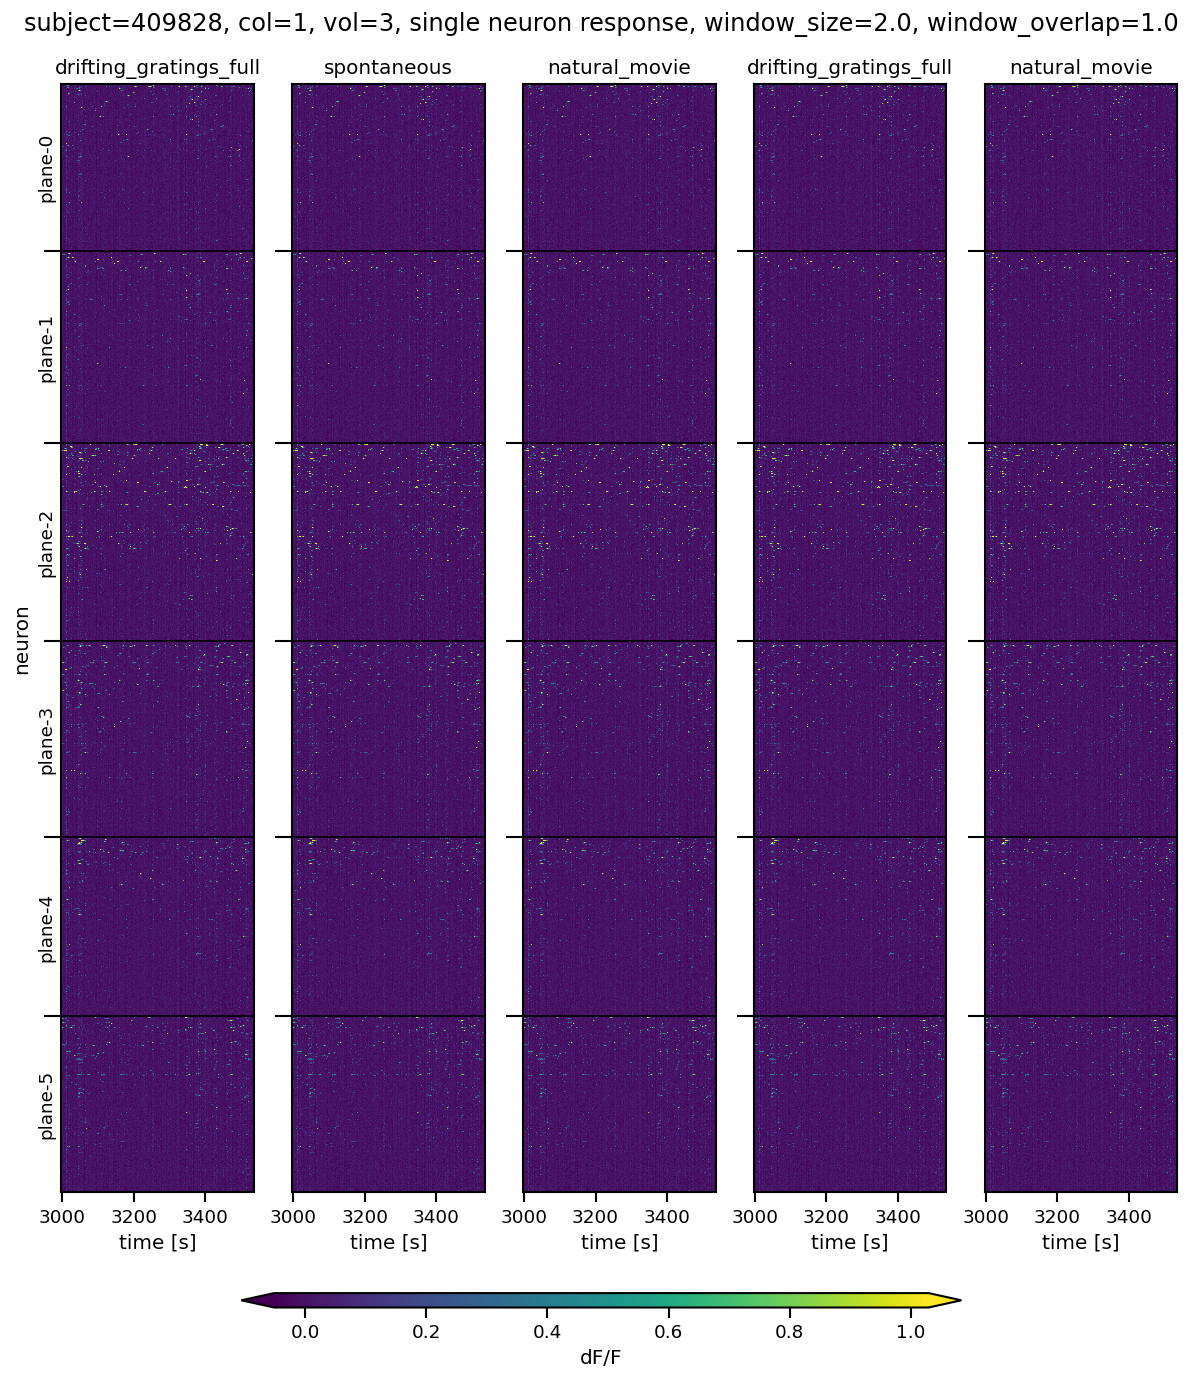

In [11]:
session_data_ = list_of_binned_epoch_data

# Share heatmap vmin and vmap across epochs
concat_dff = np.concatenate([dd['dff_traces'] for dd in session_data_], axis=0)  # (n_total_timesteps, n_total_neurons)
vmin = np.percentile(concat_dff, 1)
vmax = np.percentile(concat_dff, 99.9)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Add horizontal line indicators of planes
plane_ids = session_data_[0]['plane_ids']
y_cluster_edges = np.nonzero(plane_ids[1:] - plane_ids[:-1])[0] + 1

y_cluster_centers = np.concatenate([
    [0.5*y_cluster_edges[0]],  # first cluster
    0.5*(y_cluster_edges[1:] - y_cluster_edges[:-1]) + y_cluster_edges[:-1],
    [0.5*(len(plane_ids) - y_cluster_edges[-1]) + y_cluster_edges[-1]]  # last cluster
])

y_cluster_labels = [f'plane-{plane_id}' for plane_id in np.unique(plane_ids)]

# =========================================================================
width_ratios = np.array([len(dd['timestamps']) for dd in session_data_])

fig, axs = plt.subplots(
    ncols=len(width_ratios), width_ratios=width_ratios, sharey="row", figsize=(12,12), dpi=120,
)

for ax, dd, epoch_name in zip(axs, session_data_, stim_epochs_df['stim_name'].values):
    _dff = dd['dff_traces']  # shape (n_epoch_timesteps, n_total_cells)
    _ts = dd['timestamps']   # shape (n_epoch_timesteps,)
    
    im = ax.imshow(
        _dff.T, norm=norm, interpolation='none', aspect='auto',
        extent=[_ts[0], _ts[-1], _dff.shape[-1], 0]
    )

    # Annotate y-axis with plane id
    for edge in y_cluster_edges:
        ax.axhline(edge, color='k', lw=1)

    ax.set_yticks(y_cluster_edges)
    ax.tick_params(axis='y', labelleft=False, length=10)

    ax.set_yticks(y_cluster_centers, minor=True)
    ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
    ax.tick_params(axis='y', which='minor', left=False, length=0)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('neuron')

    ax.set_xlabel("time [s]")
    ax.set_title(epoch_name)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, label='dF/F', orientation='horizontal', extend='both')

# Add title
fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}'
    + f', single neuron response, {window_size=}, {window_overlap=}',
    y=0.95
)